```{index} single: scheduling
```
```{index} single: solver; HiGHS
```
```{index} network optimization
```
```{index} graph coloring
```
```{index} networkx
```

# 4.4 Exam room scheduling

## Preamble: Install Pyomo and a solver

The following cell sets and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and the HiGHS solver, while, if run elsewhere, it assumes Pyomo and HiGHS have been previously installed. It then sets to use HiGHS as solver via the appsi module and a test is performed to verify that it is available. The solver interface is stored in a global object `SOLVER` for later use.

# FIX APPLIED BELOW

works as of 12/19/2023

In [15]:
if 'google.colab' in sys.modules:
    %pip install pyomo >/dev/null 2>/dev/null
    %pip install highspy >/dev/null 2>/dev/null
    !apt-get install -y -qq coinor-cbc > coinor-cbc.log
    import sys
    solver = 'cbc'
    import pyomo.environ as pyo
    SOLVER = pyo.SolverFactory(solver, executable='/usr/bin/cbc')


In [16]:
assert SOLVER.available(), f"Solver {solver} is not available."

In [17]:
!which cbc

/usr/bin/cbc


## Problem description

In a small university, there is a single lecture hall that is suitable for exams. Consider the problem of choosing the time slots for each exam among a finite number of available time slots during the same week. Assume that the lecture hall is large enough to accommodate any number of exams in parallel. Since many courses are taken by the same students, exams for two courses that share at least one student cannot be scheduled in the same time slot. Every time slot the lecture hall is allocated for an exam has some indirect costs related to the hiring of temporary staff to invigilate the exams. The goal is thus to use as few time slots as possible while obeying the above restriction.

## Mathematical formulation

The scheduling problem above can be modeled as a **graph coloring problem**.

Consider an undirected graph $G=(V,E)$ consisting of a set $V$ of nodes and a collection $E\subseteq V \times V$ of edges. Each node $v \in V$ represents a course and two nodes are connected by an edge $e \in E$ whenever at least one student takes the exams for both the corresponding courses.

Finding a conflict-free exam schedule is equivalent to finding a **graph coloring** of $G$, i.e., an assignment of colors to the vertices of $G$ such that no two adjacent vertices share the same color. In particular, in the formulation above we want to use the *smallest number of colors possible*.

We can formulate this problem using MILO as follows. Consider $K$ possible colors (time slots) and define the following decision variables:

- $w_{k} \in \{0, 1\}$, $k = 1, \ldots, K$ is equal to 1 if the $k$-th color (time slot) is used;

- $x_{ik} \in \{0, 1\}$, $i \in V$, $k = 1,\dots,K$ is equal to 1 if the node (course) $i$ is assigned the $k$-th color (time slot).

Using these variables, we can formulate the minimum graph coloring problem as:

$$
\begin{align*}
    \min \quad & \sum_{k=1}^K w_k \\
    \text{s.t.} \quad
    & x_{ik} + x_{jk} \leq 1 && \forall \, (i, j) \in E, \, \forall \, k = 1,\dots,K \\
    & x_{ik} \leq w_k && \forall \, i \in V, \, \forall \, k = 1,\dots,K\\
    & \sum_{i \in V} x_{ik} = 1 && \forall \, k = 1,\dots,K\\
    & w_{k} \in \{ 0, 1 \} && \forall \, k = 1,\dots,K\\
    & x_{ik} \in \{ 0, 1 \} && \forall \, i \in V, \, \forall \, k = 1,\dots,K.
\end{align*}
$$

In this formulation, the objective function tries to minimize the number of colors used, while the constraints ensure that (i) two connected nodes do not share the same color, (ii) only a color $k$ that is being used can be assigned to a node $i$, and (iii) each node has to be assigned exactly one color. The optimal solution of this problem is known as the **chromatic number** of the graph $G$ and corresponds to the minimum number of time slots needed to schedule all exams.

In the rest of the notebook, for simplicity, we will use the graph terminology but an interested reader should be able easily interpret the results back in the scheduling context.

The following cell defines the graph coloring problem in Pyomo. The function `graph_coloring` besides a networkx graph object `G` takes as optional argument the maximum number `K` of colors to use in the model. Note that this might result in an infeasible model if `K` is too small. The other optional argument `catch_infeasibility` is used precisely to diagnose the model infeasibility without raising errors.

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter as pc


def graph_coloring(G, K=7):
    m = pyo.ConcreteModel("Graph Coloring")

    m.colors = pyo.RangeSet(0, K - 1)
    m.nodes = pyo.Set(initialize=list(G.nodes))
    m.edges = pyo.Set(initialize=list(G.edges), dimen=2)

    m.x = pyo.Var(m.nodes, m.colors, domain=pyo.Binary)
    m.w = pyo.Var(m.colors, domain=pyo.Binary)

    @m.Constraint(m.edges, m.colors)
    def edge_constraint(m, i, j, k):
        return m.x[i, k] + m.x[j, k] <= 1

    @m.Constraint(m.nodes)
    def node_constraint(m, i):
        return pyo.quicksum(m.x[i, k] for k in m.colors) == 1

    @m.Constraint(m.nodes, m.colors)
    def used_color_constraint(m, i, k):
        return m.x[i, k] <= m.w[k]

    @m.Objective(sense=pyo.minimize)
    def number_used_colors(m):
        return pyo.quicksum(m.w[k] for k in m.colors)

    return m


def get_coloring(m):
    coloring = {}
    for i in m.nodes:
        for k in m.colors:
            if round(m.x[i, k]()) == 1:
                coloring[i] = k
    unique_labels = set(coloring.values())
    tab20 = plt.get_cmap("tab20")
    color_palette = [tab20(i) for i in range(0, 20, 2)]
    label_to_color = {
        label: color for label, color in zip(unique_labels, color_palette)
    }
    return [label_to_color[coloring[key]] for key in sorted(coloring.keys())]

Let us now solve this problem for a small example. We generate a random graph using the Erdos-Renyi $(n,p)$ model. Since we are interested in a connected graph, we keep generating random graphs changing the random seed until we obtained a connected one.

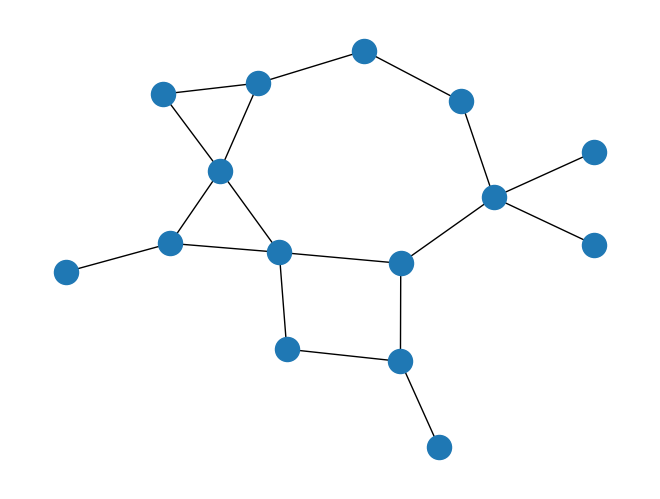

In [19]:
n = 15
p = 3 / n

seed = 1
G = nx.gnp_random_graph(n, p, seed=seed)
while not nx.is_connected(G):
    seed += 1
    G = nx.gnp_random_graph(n, p, seed=seed)

pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=False)

If we have a reasonable upper bound on the number of colors necessary, we can set it using the optional argument `K`. Otherwise, the default for the model is `K=10`.

The chromatic number of G is: 3


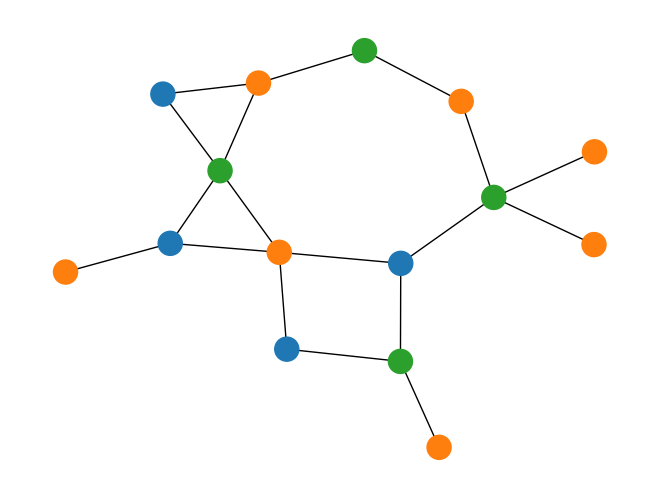

In [20]:
K = 4
m = graph_coloring(G, K)
SOLVER.solve(m)
print(f"The chromatic number of G is: {int(m.number_used_colors())}")
nx.draw(G, pos=pos, with_labels=False, node_color=get_coloring(m))

Alternatively, especially if we do not have a good guess for the upper bound of colors which are necessary, instead of choosing a very large `K` which would make the MILO much larger and slower to solve, we can take an alternative approach.

Let us start by creating a much larger connected graph with the same strategy as before.

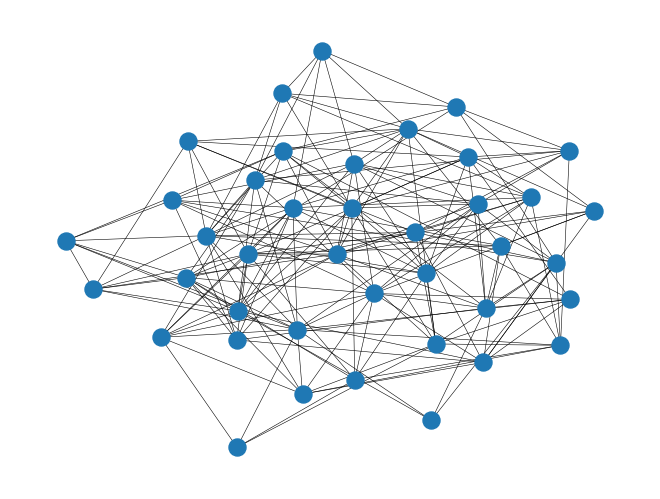

In [21]:
n = 40
p = 10 / n
seed = 1
G = nx.gnp_random_graph(n, p, seed=seed)
while not nx.is_connected(G):
    seed += 1
    G = nx.gnp_random_graph(n, p, seed=seed)

pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=False, node_size=150, width=0.4)
plt.show()

2 colors are not enough
3 colors are not enough
4 colors are not enough
The chromatic number of G is: 5
Time elapsed: 17.35 seconds


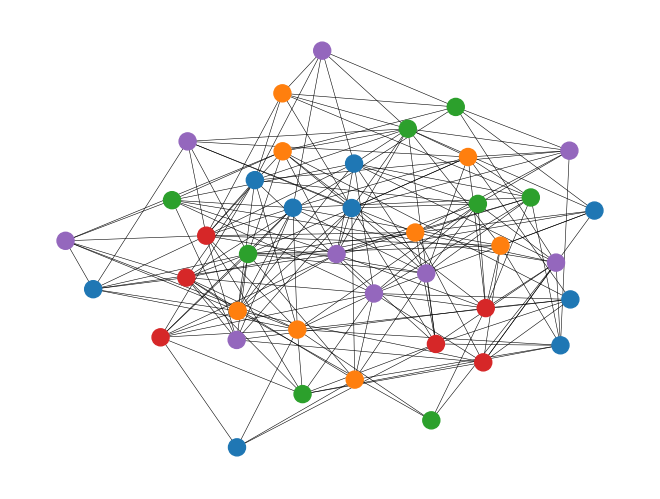

In [22]:
start_time = pc()
K = 2
while True:
    m = graph_coloring(G, K)
    # solve the model avoid raising an exception (by not loading the solution)
    results = SOLVER.solve(m, load_solutions=False)
    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        m = graph_coloring(G, K)
        results = SOLVER.solve(m, load_solutions=True)
        print(f"The chromatic number of G is: {K}")
        print(f"Time elapsed: {pc() - start_time:.2f} seconds")
        break
    else:
        print(f"{K} colors are not enough")
        K += 1

nx.draw(
    G, pos=pos, with_labels=False, node_size=150, width=0.4, node_color=get_coloring(m)
)
plt.show()

This approach is much faster than solving the same MILO with a large `K`, say 10, which results in a much larger model, both in terms of number of variables and constraints.

In [13]:
start_time = pc()
m = graph_coloring(G, K=10)
SOLVER.solve(m)
print(f"The chromatic number of G is: {int(m.number_used_colors())}")
print(f"Time elapsed: {pc() - start_time:.2f} seconds")

The chromatic number of G is: 5
Time elapsed: 99.95 seconds


The `networkx` library has a greedy graph coloring algorithm which we can use to find a good upper bound for the number of colors needed. Note, however, that this is not guaranteed to be the minimum number of colors needed.

In [14]:
start_time = pc()
nxcoloring = nx.algorithms.coloring.greedy_color(G)
K = len(set(nxcoloring.values()))
print(
    f"Upper bound found by networkx: K={K}. This will be used as the parameter of the optimization model."
)
m = graph_coloring(G, K)
SOLVER.solve(m)
print(f"The chromatic number of G is: {int(m.number_used_colors())}")
print(f"Time elapsed: {pc() - start_time:.2f} seconds")

Upper bound found by networkx: K=6. This will be used as the parameter of the optimization model.
The chromatic number of G is: 5
Time elapsed: 5.38 seconds
